In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Upper boundary as defined by the position of the steepest decline in the transverse velocity in the F4 run

In [23]:
import os
import sys
cwd = os.getcwd()
#sys.path.insert(0, '/astro/andrassy/notebooks/lib/lcse')
sys.path.insert(0, '/rpod2/home/andrassy/notebooks/lib/lcse')
import rprofile as rprofile
import numpy as np
import utils
from matplotlib import rcParams
from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib nbagg
import scipy.interpolate as interpolate

data_path = "/rpod2/PPM/RProfiles/AGBTP_M2.0Z1.e-5/F4/"
rp_set = rprofile.rprofile_set(data_path)
rp0 = rp_set.get_dump(rp_set.dumps[0])
n_buckets = rp0.get('nbuckets')
nr = len(rp0.get('y'))

# Radial interval in that the minimum of the transverse
# velocity will be looked for.
r1 = 27.
r2 = 31.

cb = utils.colourblind

In [24]:
def analyse_dump(rp, r1, r2):
    '''
    This function analyses ray profiles of one dump and returns

    r, ut, dutdr, r_ub, avg_r_ub, sigmap_r_ub, sigmam_r_ub

    where

    r: radius,
    ut: RMS tangential velocity profiles for all buckets (except the 0th),
    dutdr: radial gradient of ut for all buckets (except the 0th),
    r_ub: radius of the upper boundary as defined by the minimum in dutdr
          for all buckets  (except the 0th).
    avg_r_ub: average of r_ub
    sigmap_r_ub: standard deviation for positive fluctuations in r_ub
    sigmam_r_ub: standard deviation for negative fluctuations in r_ub
    
    Parameters:
    rp: radial profile
    r1: minimum radius for the search for r_ub
    r2: maximum radius for the search for r_ub
    '''
    n_buckets = rp.get('nbuckets')
    
    r = rp.get_table('y')
    dr = 0.5*(np.roll(r, -1) - np.roll(r, +1))
    
    idx1 = np.argmin(np.abs(r - r1))
    idx2 = np.argmin(np.abs(r - r2))
    
    ekt = rp.get_table('ekt')
    ut = ekt[0, :, 1:n_buckets+1]**0.5

    dut = 0.5*(np.roll(ut, -1, axis = 0) - np.roll(ut, +1, axis = 0))
    dutdr = np.transpose(np.array([dut[:, i]/dr for i in range(n_buckets)]))
    
    idx_min_dutdr = [idx1 + np.argmin(dutdr[idx1:idx2 + 1, i]) \
                     for i in range(n_buckets)]
    r_ub = np.zeros(n_buckets)

    for bucket in range(n_buckets):
        idx = idx_min_dutdr[bucket]
        r_min = r[idx] # 0th-order estimate

        # try to fit a parabola around r_min
        r_fit = r[idx-1:idx+2]
        dutdr_fit = dutdr[idx-1:idx+2, bucket]
        coefs = np.polyfit(r_fit, dutdr_fit, 2)
        
        # hopefully we can determine the position of the minimum from the fit
        if coefs[0] != 0:
            r_min = -coefs[1]/(2.*coefs[0])
            # go back to 0th order if something has gone awry with the fit
            if r_min < r[idx -1] or r_min > r[idx + 1]:
                r_min = r[idx]
        
        r_ub[bucket] = r_min
        
        avg_r_ub = np.sum(r_ub)/float(n_buckets)
        dev = np.array([r_ub[i] - avg_r_ub for i in range(n_buckets)])
        sigmap_r_ub = 0.
        sigmam_r_ub = 0.
        devp = dev[dev >= 0]
        if len(devp) > 0:
            sigmap_r_ub = (sum(devp**2)/float(len(devp)))**0.5
        else:
            sigmap_r_ub = None

        devm = dev[dev <= 0]
        if len(devm) > 0:
            sigmam_r_ub = (sum(devm**2)/float(len(devm)))**0.5
        else:
            sigmam_r_ub = None
        
    return r, ut, dutdr, r_ub, avg_r_ub, sigmap_r_ub, sigmam_r_ub

def ut_plots(dump, hist_dmin, hist_dmax, r_lim, ut_lim, dutdr_lim, N_lim, ifig0):
    # Find the dumps closest to those we want.
    idx = np.argmin(np.abs(dumps - dump))
    dump = dumps[idx]
    hist_imin = np.argmin(np.abs(dumps - hist_dmin))
    hist_dmin = dumps[hist_imin]
    hist_tmin = t[hist_imin]
    hist_imax = np.argmin(np.abs(dumps - hist_dmax))
    hist_dmax = dumps[hist_imax]
    hist_tmax = t[hist_imax]

    hist_bins = 0.5*(r + np.roll(r, -1))
    hist_bins[-1] = hist_bins[-2] + (hist_bins[-2] - hist_bins[-3])
    hist_bins = np.insert(hist_bins, 0., 0.)

    print "Dump {:d} (t = {:.2f} min).".format(dumps[idx], t[idx]/60.)
    print "Histogram constructed using {:d} dumps from {:d} (t = {:.2f} min) to {:d} (t = {:.2f} min) inclusive."\
          .format(hist_imax - hist_imin + 1, hist_dmin, hist_tmin/60., hist_dmax, hist_tmax/60.)
    print 'Sparsity is {:d}.'.format(sparse)

    ifig = ifig0; plt.close(ifig); fig = plt.figure(ifig, figsize = (3.39, 2.8))
    gs = gridspec.GridSpec(2, 1, height_ratios = [3, 1])
    ax0 = plt.subplot(gs[0])
    for bucket in range(n_buckets):
        lbl = r'bucket data' if bucket == 0 else None
        ax0.plot(r, 1e3*ut[:, bucket, idx], ls = '-', lw = 0.5, color = cb(3), \
                 label = lbl)
    for bucket in range(n_buckets):
        int_func = interpolate.interp1d(r, ut[:, bucket, idx])
        rm = r_ub[bucket, idx]
        lbl = r'steepest decline'
        lbl = lbl if bucket == 0 else None
        ax0.plot(rm, 1e3*int_func(rm), ls='', marker='.', color=cb(4), label=lbl)
        
    ax0.axvline(x = avg_r_ub[idx], ls = '--', lw = 1., color = cb(4), label = 'average')
    ax0.axvline(x = avg_r_ub[idx] - 2*sigmam_r_ub[idx], ls = ':', lw = 1., \
                color = cb(4), label = '2$\sigma$ fluctuations')
    ax0.axvline(x = avg_r_ub[idx] + 2*sigmap_r_ub[idx], ls = ':', lw = 1., color = cb(4))
    ax0.set_xlim(r_lim)
    ax0.set_ylim(ut_lim)
    ax0.set_ylabel(r'v$_{\!\perp}$ / km s$^{-1}$')
    yticks = ax0.yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False)
    ax0.legend(loc = 1, frameon = False)

    ax1 = plt.subplot(gs[1])
    ax1.hist(r_ub[:, hist_imin:hist_imax+1].flatten(), bins = hist_bins, \
             log = True, color = cb(3), edgecolor = cb(4), lw = 0.5)
    ax1.axvline(x = avg_r_ub[idx], ls = '--', lw = 1., color = cb(4))
    ax1.axvline(x = avg_r_ub[idx] - 2*sigmam_r_ub[idx], ls = ':', lw = 1., color = cb(4))
    ax1.axvline(x = avg_r_ub[idx] + 2*sigmap_r_ub[idx], ls = ':', lw = 1., color = cb(4))
    ax1.set_xlim(r_lim)
    ax1.set_ylim(N_lim)
    ax1.set_xlabel(r'r / Mm')
    ax1.set_ylabel(r'N')
    ax1.minorticks_off()
    fig.subplots_adjust(hspace = 0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible = False)
    plt.savefig('F4_vt_ub_{:04d}.pdf'.format(dumps[idx]))

    print "Dump {:d} (t = {:.2f} min).".format(dumps[idx], t[idx]/60.)
    print "Histogram constructed using {:d} dumps from {:d} (t = {:.2f} min) to {:d} (t = {:.2f} min) inclusive."\
          .format(hist_imax - hist_imin + 1, hist_dmin, hist_tmin/60., hist_dmax, hist_tmax/60.)
    print 'Sparsity is {:d}.'.format(sparse)

    ifig = ifig0 + 1; plt.close(ifig); fig = plt.figure(ifig, figsize = (3.39, 2.8))
    gs = gridspec.GridSpec(2, 1, height_ratios = [3, 1])
    ax0 = plt.subplot(gs[0])
    for bucket in range(n_buckets):
        lbl = r'bucket data' if bucket == 0 else None
        ax0.plot(r, dutdr[:, bucket, idx], ls = '-', lw = 0.5, color = cb(3), \
                 label = lbl)
    for bucket in range(n_buckets):
        int_func = interpolate.interp1d(r, dutdr[:, bucket, idx])
        rm = r_ub[bucket, idx]
        lbl = r'minimum'
        lbl = lbl if bucket == 0 else None
        ax0.plot(rm, int_func(rm), ls='', marker='.', color=cb(4), label=lbl)

    ax0.axvline(x = avg_r_ub[idx], ls = '--', lw = 1., color = cb(4), label = 'average')
    ax0.axvline(x = avg_r_ub[idx] - 2*sigmam_r_ub[idx], ls = ':', lw = 1., \
                color = cb(4), label = '2$\sigma$ fluctuations')
    ax0.axvline(x = avg_r_ub[idx] + 2*sigmap_r_ub[idx], ls = ':', lw = 1., color = cb(4))
    ax0.set_xlim(r_lim)
    ax0.set_ylim(dutdr_lim)
    ax0.set_ylabel(r'($\partial$v$_{\!\perp}$/$\partial$r) / s$^{-1}$')
    ax0.legend(loc = 4, frameon = False)

    ax1 = plt.subplot(gs[1])
    ax1.hist(r_ub[:, hist_imin:hist_imax+1].flatten(), bins = hist_bins, \
             log = True, color = cb(3), edgecolor = cb(4), lw = 0.5)
    ax1.axvline(x = avg_r_ub[idx], ls = '--', lw = 1., color = cb(4))
    ax1.axvline(x = avg_r_ub[idx] - 2*sigmam_r_ub[idx], ls = ':', lw = 1., color = cb(4))
    ax1.axvline(x = avg_r_ub[idx] + 2*sigmap_r_ub[idx], ls = ':', lw = 1., color = cb(4))
    ax1.set_xlim(r_lim)
    ax1.set_ylim(N_lim)
    ax1.set_xlabel(r'r / Mm')
    ax1.set_ylabel(r'N')
    ax1.minorticks_off()
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible = False)
    plt.savefig('F4_dvtdr_ub_{:04d}.pdf'.format(dumps[idx]))

In [25]:
sparse = 1
dumps = np.array([rp_set.dumps[i] for i in range(0, len(rp_set.dumps), sparse)])
n_dumps = len(dumps)

t = np.zeros(n_dumps)
r_ub = np.zeros((n_buckets, n_dumps))
ut = np.zeros((nr, n_buckets, n_dumps))
dutdr = np.zeros((nr, n_buckets, n_dumps))
avg_r_ub = np.zeros(n_dumps)
sigmap_r_ub = np.zeros(n_dumps)
sigmam_r_ub = np.zeros(n_dumps)
for k in range(n_dumps):
    rp = rp_set.get_dump(dumps[k])
    t[k] = rp.get('time')
    
    res = analyse_dump(rp, r1, r2)
    r = res[0]
    ut[:, :, k] = res[1]
    dutdr[:, :, k] = res[2]
    r_ub[:, k] = res[3]
    avg_r_ub[k] = res[4]
    sigmap_r_ub[k] = res[5]
    sigmam_r_ub[k] = res[6]
        
t_fit_start = 1.8e4

idx_fit_start = np.argmin(np.abs(t - t_fit_start))
t_fit_start = t[idx_fit_start]

# fc = fit coefficients
fc_avg = np.polyfit(t[idx_fit_start:-1], avg_r_ub[idx_fit_start:-1], 1)
avg_fit = fc_avg[0]*t + fc_avg[1]
fc_plus = np.polyfit(t[idx_fit_start:-1], 2.*sigmap_r_ub[idx_fit_start:-1], 1)
plus_fit = fc_plus[0]*t + fc_plus[1]
fc_minus = np.polyfit(t[idx_fit_start:-1], 2.*sigmam_r_ub[idx_fit_start:-1], 1)
minus_fit = fc_minus[0]*t + fc_minus[1]

## End of the no-burn phase

Dump 560 (t = 807.79 min).
Histogram constructed using 101 dumps from 510 (t = 735.67 min) to 610 (t = 879.92 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


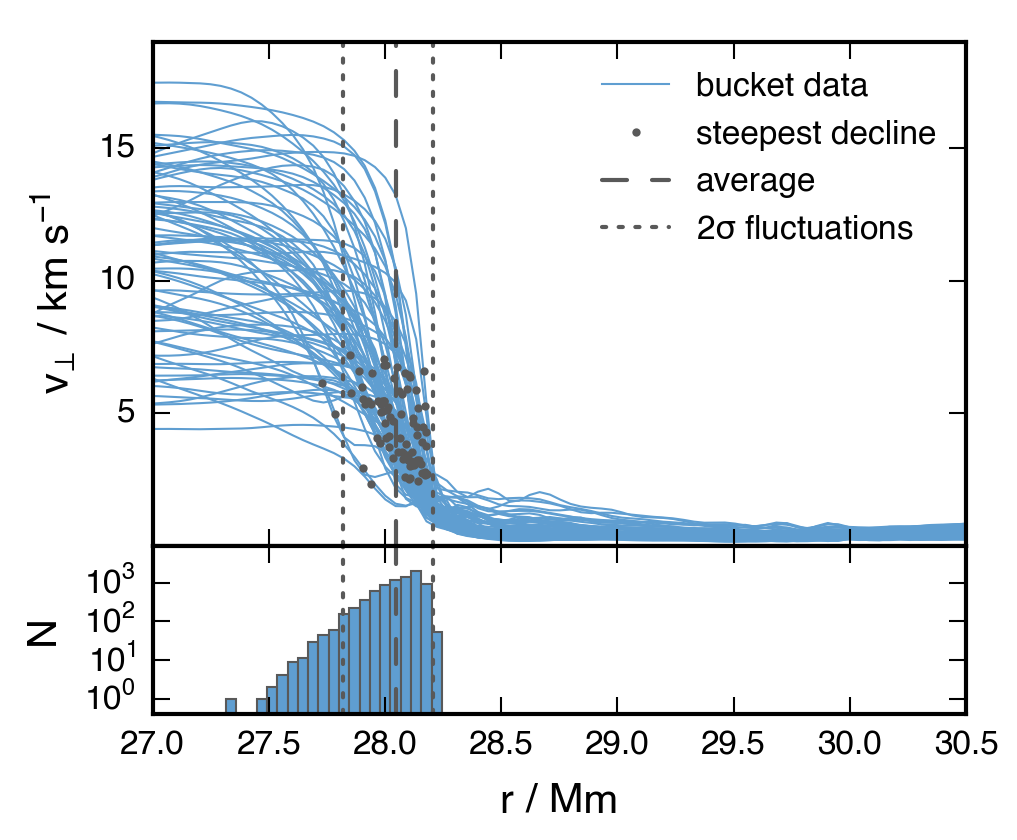

Dump 560 (t = 807.79 min).
Histogram constructed using 101 dumps from 510 (t = 735.67 min) to 610 (t = 879.92 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


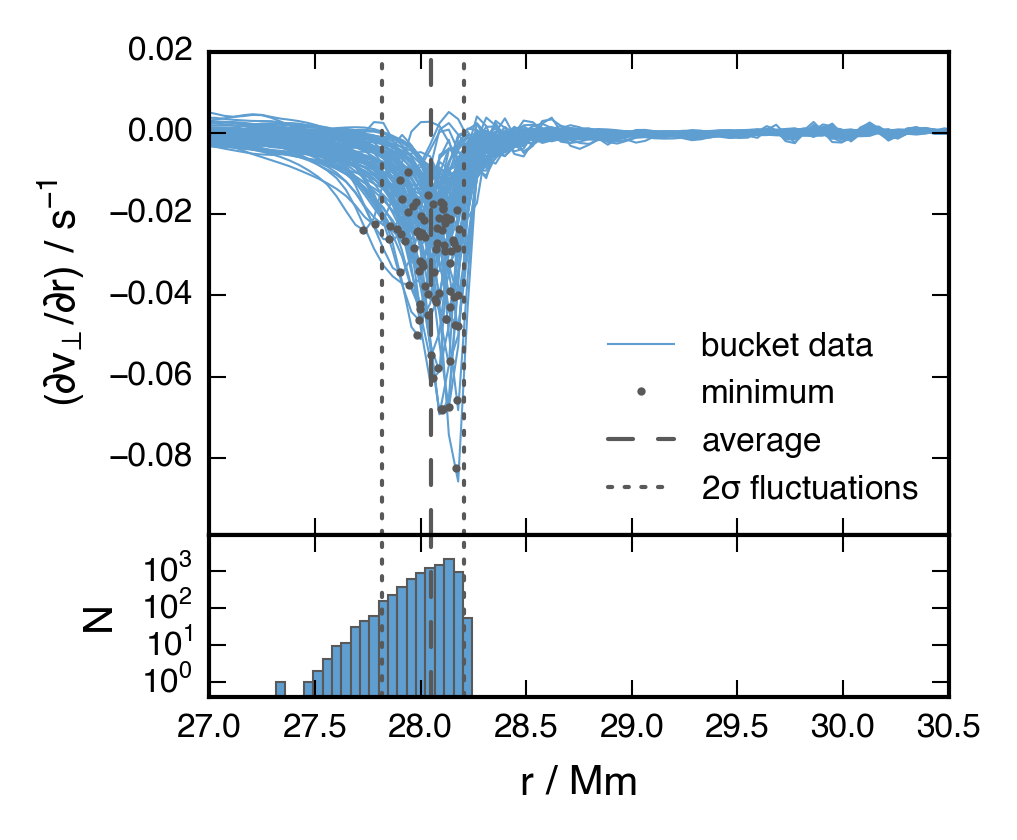

In [44]:
dump = 560
hist_dmin = dump - 50
hist_dmax = dump + 50
r_lim = (27.0, 30.5)
ut_lim = (1e-3, 19.)
dutdr_lim = (-0.099, 0.02)
N_lim = (0.4, 9000)
ifig0 = 1
ut_plots(dump, hist_dmin, hist_dmax, r_lim, ut_lim, dutdr_lim, N_lim, ifig0)

## Well into the burn-on phase, but also well before the first GOSH

Dump 970 (t = 1399.21 min).
Histogram constructed using 101 dumps from 920 (t = 1327.09 min) to 1020 (t = 1471.34 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


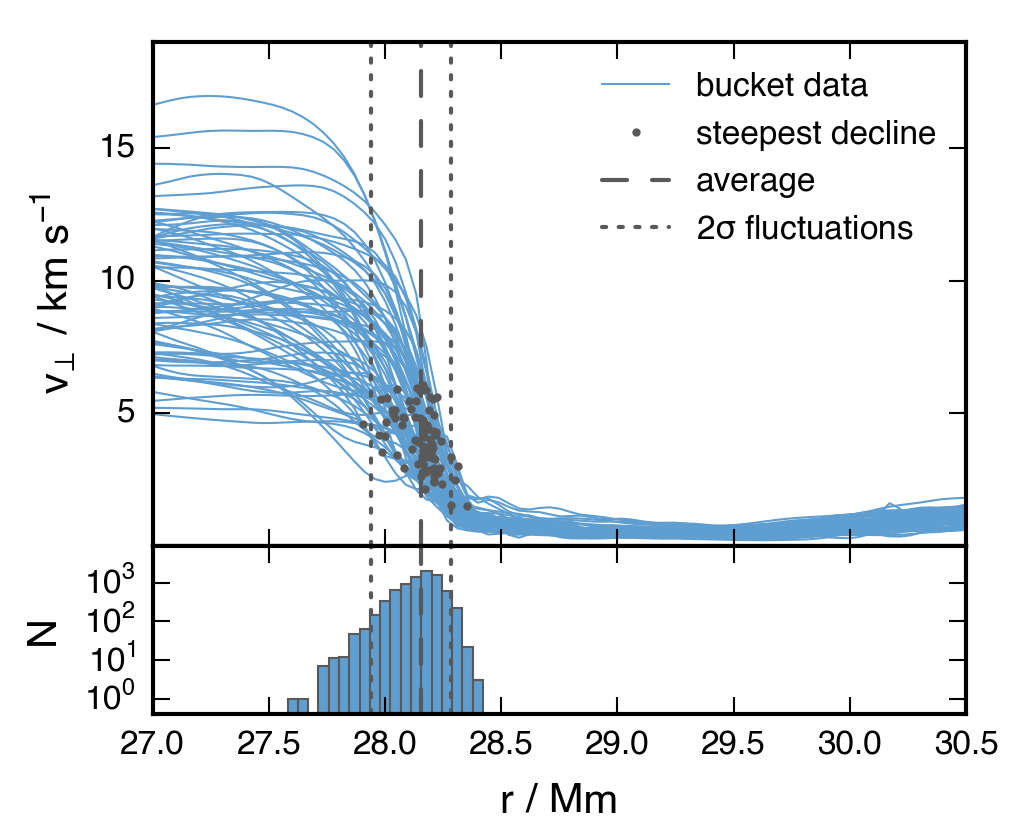

Dump 970 (t = 1399.21 min).
Histogram constructed using 101 dumps from 920 (t = 1327.09 min) to 1020 (t = 1471.34 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


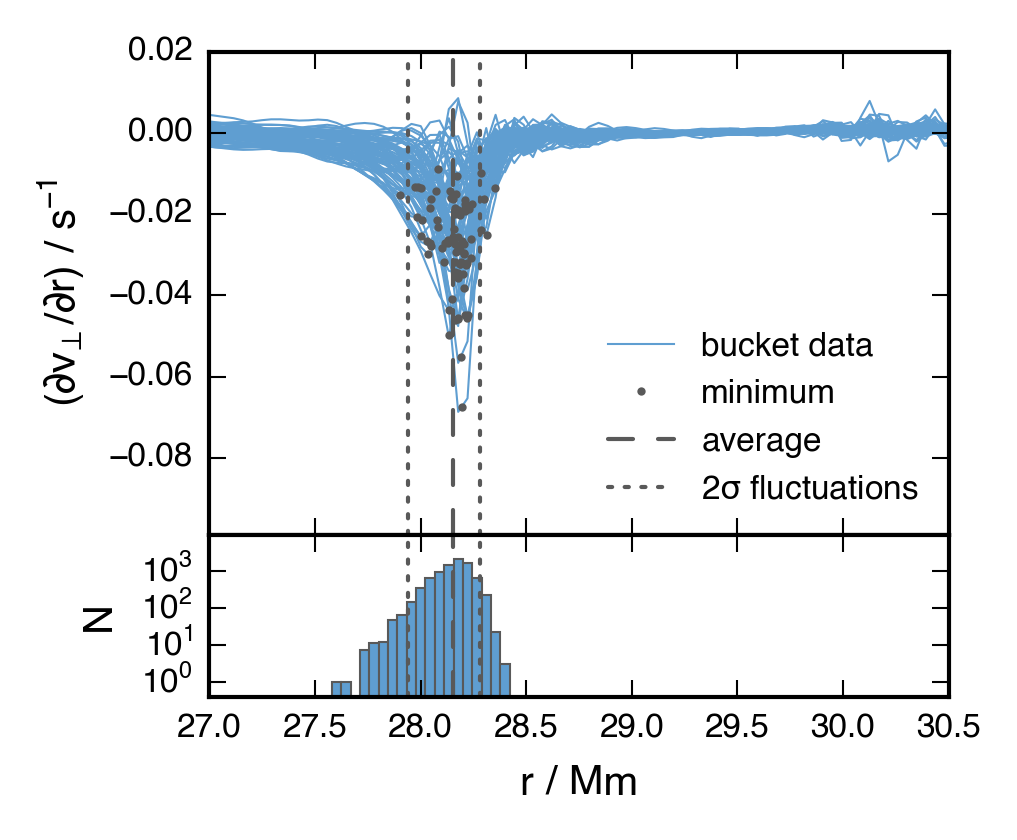

In [45]:
dump = 970
hist_dmin = dump - 50
hist_dmax = dump + 50
r_lim = (27.0, 30.5)
ut_lim = (1e-3, 19.)
dutdr_lim = (-0.099, 0.02)
N_lim = (0.4, 9000)
ifig0 = 3
ut_plots(dump, hist_dmin, hist_dmax, r_lim, ut_lim, dutdr_lim, N_lim, ifig0)

## First GOSH

Dump 1469 (t = 2119.01 min).
Histogram constructed using 101 dumps from 1419 (t = 2046.89 min) to 1519 (t = 2191.14 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


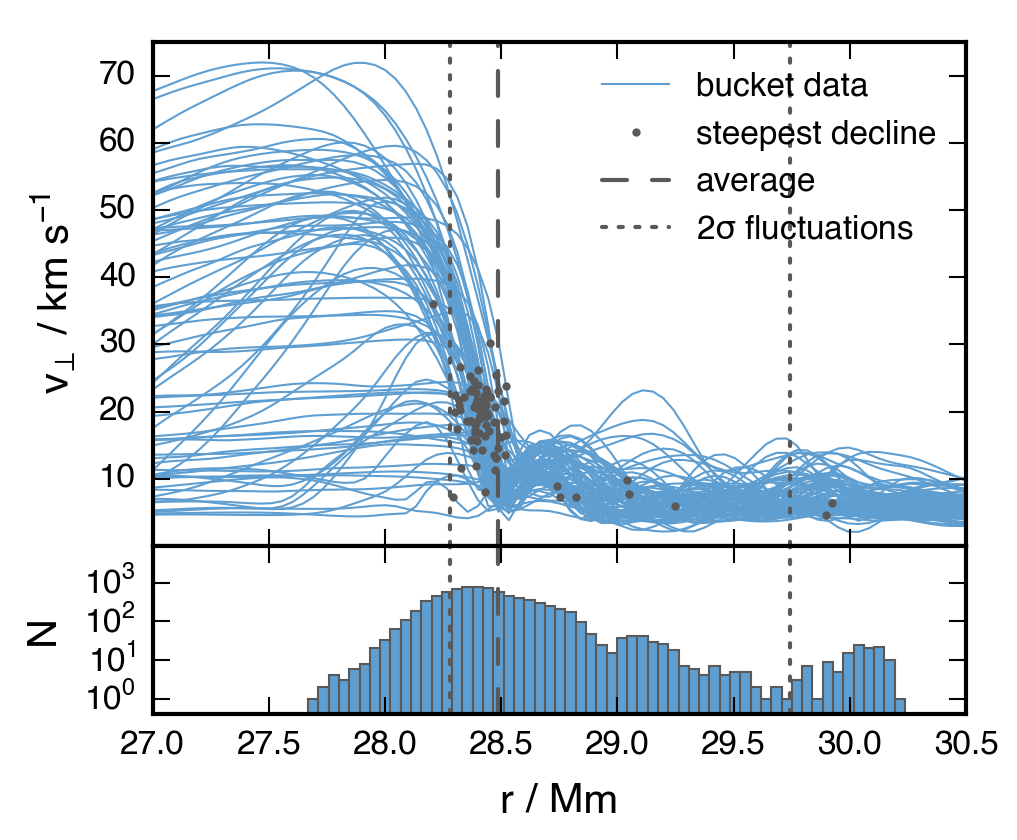

Dump 1469 (t = 2119.01 min).
Histogram constructed using 101 dumps from 1419 (t = 2046.89 min) to 1519 (t = 2191.14 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


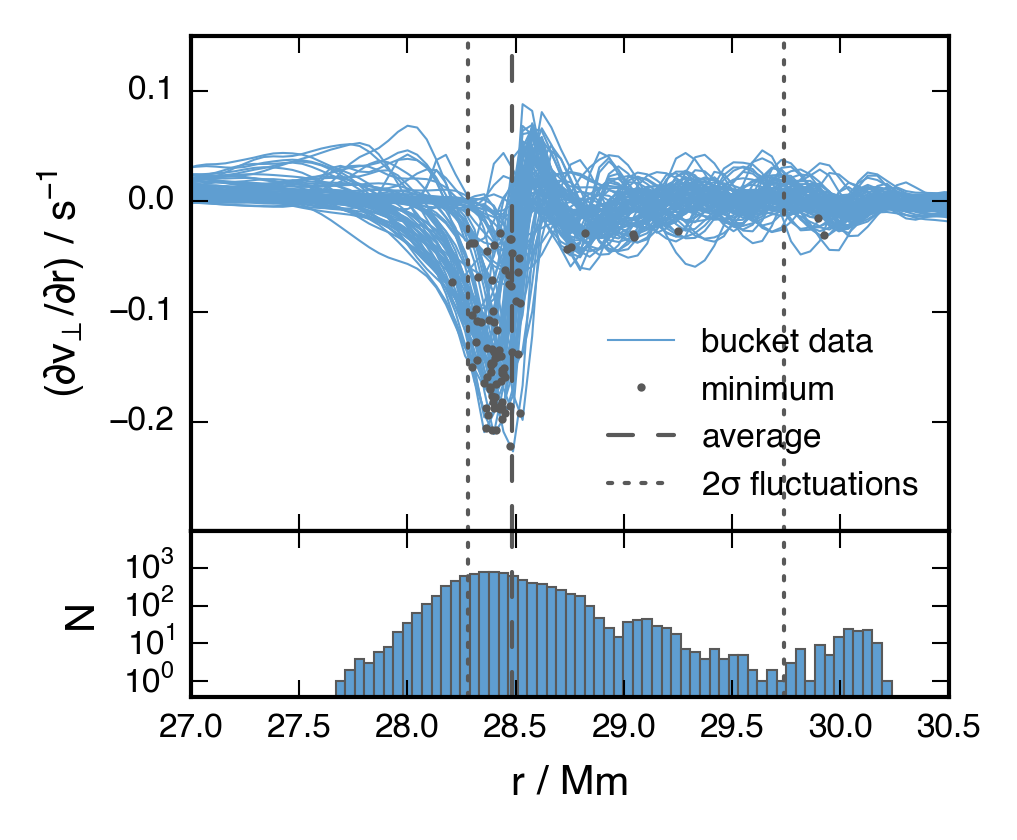

In [46]:
dump = 1469
hist_dmin = dump - 50
hist_dmax = dump + 50
r_lim = (27.0, 30.5)
ut_lim = (1e-3, 75.)
dutdr_lim = (-0.299, 0.15)
N_lim = (0.4, 9000)
ifig0 = 5
ut_plots(dump, hist_dmin, hist_dmax, r_lim, ut_lim, dutdr_lim, N_lim, ifig0)

## The calm after the storm

Dump 1630 (t = 2351.26 min).
Histogram constructed using 101 dumps from 1580 (t = 2279.13 min) to 1680 (t = 2423.38 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


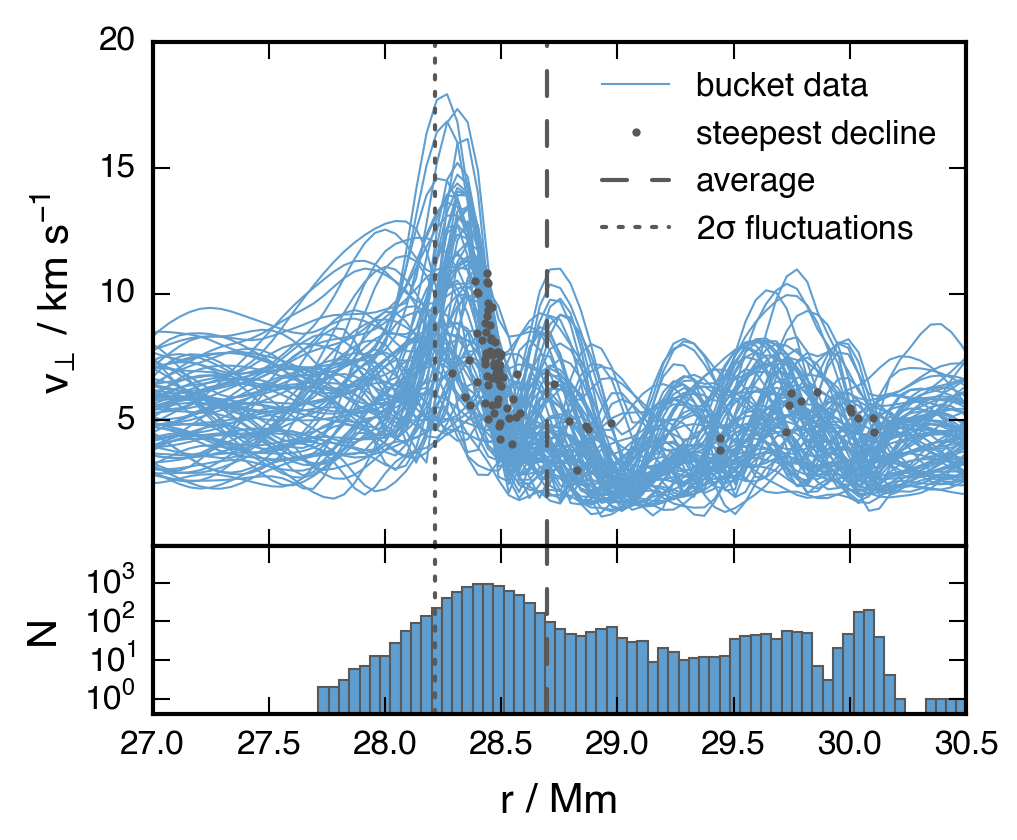

Dump 1630 (t = 2351.26 min).
Histogram constructed using 101 dumps from 1580 (t = 2279.13 min) to 1680 (t = 2423.38 min) inclusive.
Sparsity is 1.


<IPython.core.display.Javascript object>


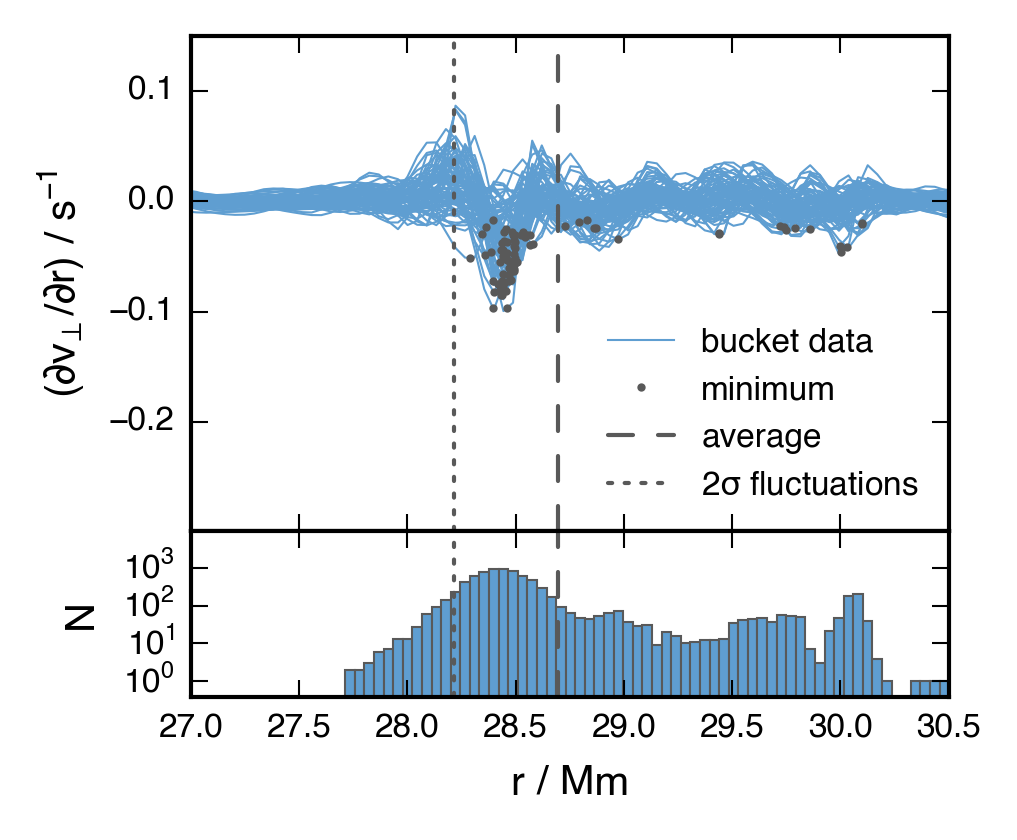

In [50]:
dump = 1630
hist_dmin = dump - 50
hist_dmax = dump + 50
r_lim = (27.0, 30.5)
ut_lim = (1e-3, 20.)
dutdr_lim = (-0.299, 0.15)
N_lim = (0.4, 9000)
ifig0 = 7
ut_plots(dump, hist_dmin, hist_dmax, r_lim, ut_lim, dutdr_lim, N_lim, ifig0)

## Temporal evolution of the boundary

<IPython.core.display.Javascript object>


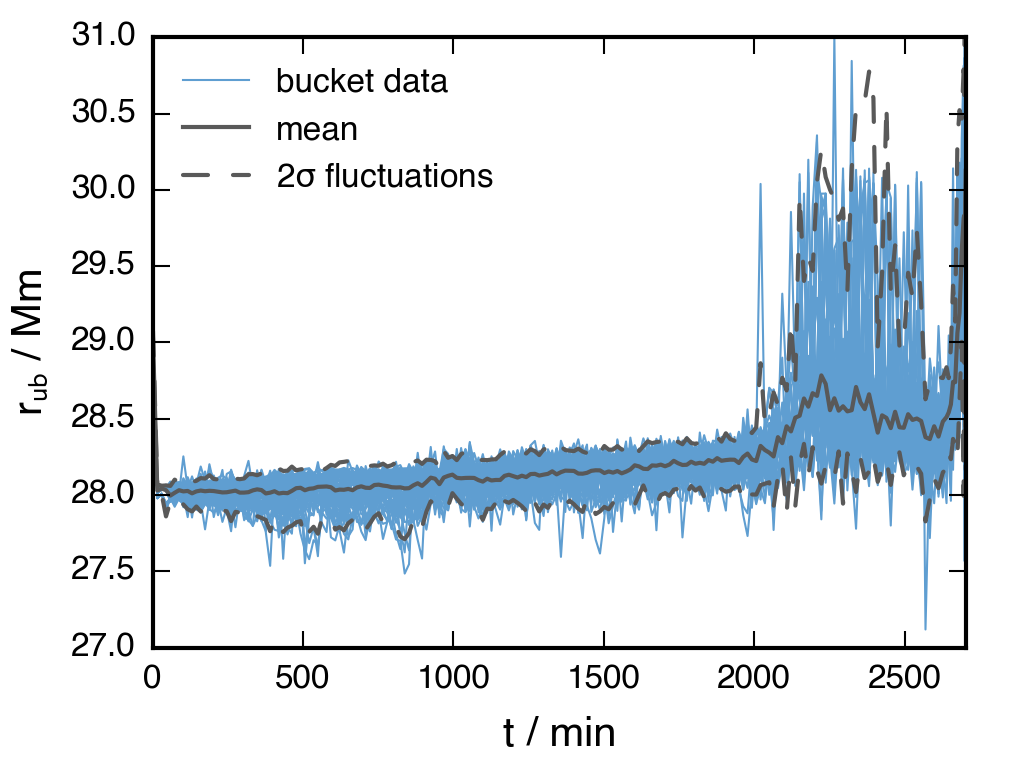

The fitting starts at t = 18002.2 s = 300.0 min.

Average:
2.772e+01 Mm + (6.216e-06 Mm/s)*t

Positive fluctuations:
-2.930e-01 Mm + (7.678e-06 Mm/s)*t

Negative fluctuations:
3.334e-02 Mm + (2.960e-06 Mm/s)*t


In [35]:
show_fits = False
sparse2 = 10

print 'Sparsity is {:d}.'.format(sparse2)

ifig = 5; plt.close(ifig); fig = plt.figure(ifig)#, figsize = (6.0, 4.7))
for bucket in range(n_buckets):
    lbl = 'bucket data' if bucket == 0 else None
    plt.plot(t[::sparse2]/60., r_ub[bucket, ::sparse2], ls = '-', lw = 0.5, color = cb(3), \
             label = lbl)
plt.plot(t[::sparse2]/60., avg_r_ub[::sparse2], ls = '-', lw = 1., color = cb(4),\
         label = 'mean')
plt.plot(t[::sparse2]/60., avg_r_ub[::sparse2] + 2*sigmap_r_ub[::sparse2], ls = '--', lw = 1., \
         color = cb(4), label = r'2$\sigma$ fluctuations')
plt.plot(t[::sparse2]/60., avg_r_ub[::sparse2] - 2*sigmam_r_ub[::sparse2], ls = '--', lw = 1., \
         color = cb(4))
if show_fits:
    plt.plot(t/60., avg_fit, ls = '-', lw = 0.5, color = cb(4), \
            label = r'$\mathregular{linear\ fits}$')
    plt.plot(t/60., avg_fit + plus_fit, ls = '-', lw = 0.5, color = cb(4))
    plt.plot(t/60., avg_fit - minus_fit, ls = '-', lw = 0.5, color = cb(4))
plt.xlim((0., np.max(t)/60.))
plt.ylim((27., 31.))
plt.xlabel('t / min')
plt.ylabel(r'r$_\mathrm{ub}$ / Mm')
plt.legend(loc = 0, frameon = False)
#fig.tight_layout()
plt.savefig('F4_r_ub_evolution.pdf')

print 'The fitting starts at t = {:.1f} s = {:.1f} min.'.format(t_fit_start, t_fit_start/60.)
print ''
print 'Average:'
print '{:.3e} Mm + ({:.3e} Mm/s)*t'.format(fc_avg[1], fc_avg[0])
print ''
print 'Positive fluctuations:'
print '{:.3e} Mm + ({:.3e} Mm/s)*t'.format(fc_plus[1], fc_plus[0])
print ''
print 'Negative fluctuations:'
print '{:.3e} Mm + ({:.3e} Mm/s)*t'.format(fc_minus[1], fc_minus[0])